# MLP

In [37]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [38]:
import letter_detection_utils as ld_util
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(ld_util)

<module 'letter_detection_utils' from '/Users/jpec/Prog/OCRpyMAN/notebooks/letter_detection/letter_detection_utils.py'>

In [39]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    # pickle_name='ld_sobel_y', 
    img_size=img_size,
    with_edge_detection = False
)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

Loading existing data from  ../../pickle/letter_detection_data.pickle ...
Length:  1000
Imgs length:  1000
Img shape:  (4096,)


# Models

## SKLEARN MLP 

In [40]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)

In [41]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    solver='lbfgs', 
    activation='relu',
    alpha=1e-4, 
    hidden_layer_sizes=(64, 256, 1024), 
    max_iter=10_000,
    random_state=42
)
# {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024)}
mlp.fit(X_train, y_train)

print(mlp.score(X_test, y_test))
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

0.2


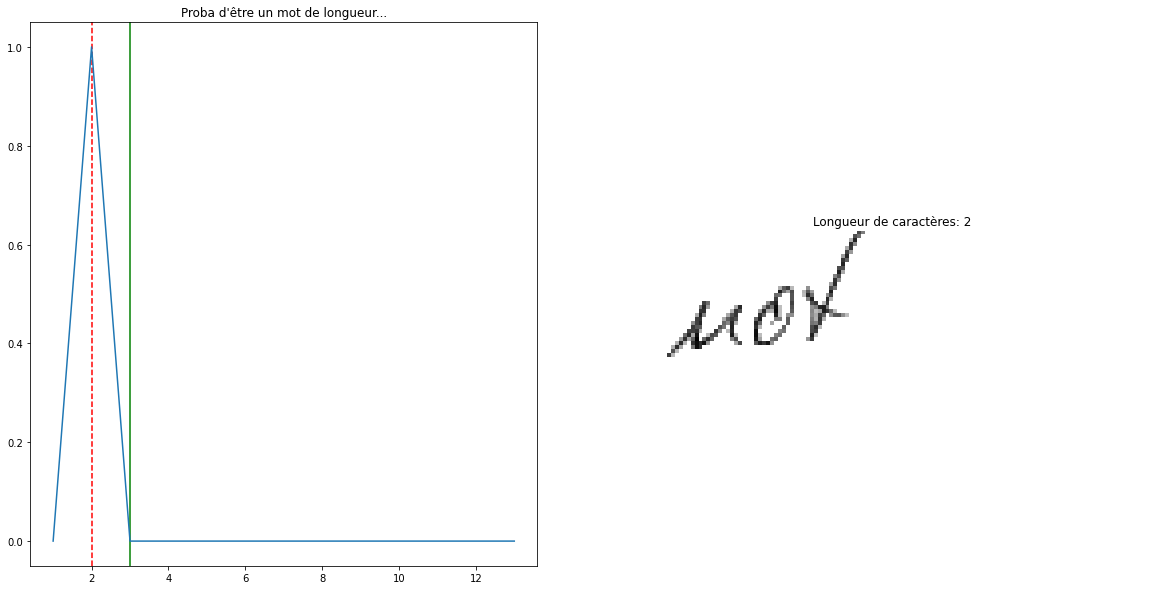

In [42]:
ld_util.show_mlp_result_for_row(X_test, y_test, y_pred, y_pred_proba, 0)

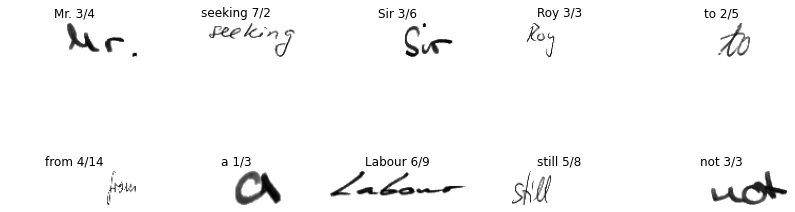

In [43]:
plt.figure(figsize=(14, 5))
j = 1
for i in np.random.randint(low=800, high=1000, size=[10]):
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(X_test[i - 800].reshape(img_size), cmap='gray');
    plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length) + '/' + str(y_pred[i - 800]))
    j+=1

## TF MLP

In [44]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)

In [45]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical



inputs = Input(shape=(X_train.shape[1]))
first_layer = Dense(16, activation='tanh', name='Dense_1')
second_layer = Dense(24, activation='tanh', name='Dense_2')
third_layer = Dense(df.length.max(), activation='linear', name='Dense_3')

outputs=first_layer(inputs)
outputs=second_layer(outputs)
outputs=third_layer(outputs)
model = Model(inputs = inputs, outputs = outputs)

In [46]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
Dense_1 (Dense)              (None, 16)                65552     
_________________________________________________________________
Dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
Dense_3 (Dense)              (None, 15)                375       
Total params: 66,335
Trainable params: 66,335
Non-trainable params: 0
_________________________________________________________________


In [50]:
import tensorflow as tf

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
training_history = model.fit(X_train, y_train, batch_size=5, epochs=20)


Train on 800 samples
Epoch 1/20
800/800 [==============================] - 1s 1ms/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 2/20
800/800 [==============================] - 0s 438us/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 3/20
800/800 [==============================] - 0s 470us/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 4/20
800/800 [==============================] - 0s 442us/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 5/20
800/800 [==============================] - 0s 448us/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 6/20
800/800 [==============================] - 0s 551us/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 7/20
800/800 [==============================] - 0s 507us/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 8/20
800/800 [==============================] - 0s 543us/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 9/20
800/800 [==============================] - 0s 451us/sample - loss: 2.7081 - accuracy: 0.0000e+00
Epoch 10/

In [48]:
model.predict(X_test)

array([[-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       ...,
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ],
       [-0.1291075 , -0.4373265 , -1.1472191 , ..., -0.62095714,
        -1.2577915 , -0.2654246 ]], dtype=float32)

## GridSearch MLP

- Solver: "lbfgs"
    Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

In [49]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neural_network import MLPClassifier


# mlp = MLPClassifier(solver='lbfgs', random_state=42, max_iter=1_000)

# params = {
#     'activation' : ['logistic', 'tanh', 'relu'],
#     'alpha': [1e-5, 1e-4, 1e-3],
#     'hidden_layer_sizes': [(2**6, 2**8), (2**6, 2**8, 2**10)],
#     # 'max_iter': [200, 500, 1_000]
# }

# grid_search = GridSearchCV(mlp, params)
# grid_search.fit(X_train, y_train)

# print('best params', grid_search.best_params_)
# print(grid_search.score(X_test, y_test))

# y_pred = grid_search.predict(X_test)
# y_pred_proba = grid_search.predict_proba(X_test)